# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:

train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 10

In [4]:
# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
img_idx = [1,3,5,7,9,11,13,15,17,19]
nb_frames = len(img_idx)  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [1,3,5,7,9,11,13,15,17,19] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)// batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),nb_rows,nb_cols,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                    #image
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = image.astype(np.float32)
                    
                    #if image.shape[0]!=image.shape[1]:
                        #image=image[0:160,20:120]
                        
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #if image.shape[0] > 120 and image.shape[1] > 120:
                        #h,w,_= image.shape
                        #image=image[int(h/2)-50:int(h/2)+50, int(wCropped:w/2)+50, : ]
                        #print('Cropped:',image)
                    #if image.shape[0] > 120 or image.shape[1] > 120:
                    image=imresize(image,[120,120]);
                    #print('Resizzed:',image)  
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                    #image
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        image = image.astype(np.float32)
                        image=imresize(image,[120,120]);
                    #print('Resizzed:',image)  
                        batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  
        yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import h5py
import matplotlib.pyplot as plt
from keras.utils import to_categorical

#write your model here

In [8]:
input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)
model=Sequential()
model.add(Conv3D(8, 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = 'sgd'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 10, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 60, 60, 16)     64        
_________________________________________________________________
activation_2 (Activation)    (None, 5, 60, 60, 16)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR]
callbacks_list =  [checkpoint,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
 1/67 [..............................] - ETA: 13s - loss: 1.5876 - categorical_accuracy: 0.3333

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 9s 138ms/step - loss: 1.4754 - categorical_accuracy: 0.3284 - val_loss: 1.3961 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2019-12-2407_30_25.158041/model-00001-1.47542-0.32836-1.39608-0.50000.h5
Epoch 2/10
67/67 [==============================] - 9s 135ms/step - loss: 1.4449 - categorical_accuracy: 0.3881 - val_loss: 1.4382 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2019-12-2407_30_25.158041/model-00002-1.44491-0.38806-1.43824-0.45000.h5
Epoch 3/10
67/67 [==============================] - 9s 131ms/step - loss: 1.4174 - categorical_accuracy: 0.4129 - val_loss: 1.4146 - val_categorical_accuracy: 0.4800

Epoch 00003: saving model to model_init_2019-12-2407_30_25.158041/model-00003-1.41745-0.41294-1.41463-0.48000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 4/10
67/67 [==============================] - 9s 132ms/step - loss: 1.4341 - categor

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Lower right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


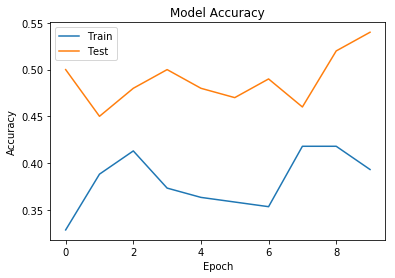

In [20]:
import matplotlib.pyplot as plt
#visualizing training history

plt.plot(history1.history['categorical_accuracy'])
plt.plot(history1.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc="Lower right")
plt.show()



##### Model defined with 
- batch_size = 50 , num_epochs = 100
- img_idx = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [21]:
# Parameters initialization
batch_size = 50
num_epochs = 100 # choose the number of epochs
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
img_idx = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]
nb_frames = len(img_idx)  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list =  [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/100


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 4s - loss: 1.4048 - categorical_accuracy: 0.4100

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 30s 2s/step - loss: 1.4498 - categorical_accuracy: 0.3914 - val_loss: 1.4038 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2019-12-2407_30_25.158041/model-00001-1.44979-0.39143-1.40376-0.50000.h5
Epoch 2/100
14/14 [==============================] - 7s 499ms/step - loss: 1.3684 - categorical_accuracy: 0.3901 - val_loss: 1.4317 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2019-12-2407_30_25.158041/model-00002-1.36842-0.39011-1.43168-0.50000.h5
Epoch 3/100
14/14 [==============================] - 8s 573ms/step - loss: 1.3598 - categorical_accuracy: 0.4505 - val_loss: 1.3765 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2019-12-2407_30_25.158041/model-00003-1.35985-0.45055-1.37646-0.50000.h5
Epoch 4/100
14/14 [==============================] - 8s 557ms/step - loss: 1.3780 - categorical_accuracy: 0.4670 - val_loss: 1.4026 - val_categorical_accuracy: 0.5100

Epo


Epoch 00027: saving model to model_init_2019-12-2407_30_25.158041/model-00027-1.40002-0.39011-1.36819-0.54000.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 7.629394360719743e-08.
Epoch 28/100
14/14 [==============================] - 8s 556ms/step - loss: 1.4512 - categorical_accuracy: 0.3736 - val_loss: 1.3993 - val_categorical_accuracy: 0.5200

Epoch 00028: saving model to model_init_2019-12-2407_30_25.158041/model-00028-1.45120-0.37363-1.39926-0.52000.h5
Epoch 29/100
14/14 [==============================] - 7s 516ms/step - loss: 1.3992 - categorical_accuracy: 0.3846 - val_loss: 1.3834 - val_categorical_accuracy: 0.4600

Epoch 00029: saving model to model_init_2019-12-2407_30_25.158041/model-00029-1.39924-0.38462-1.38335-0.46000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.814697180359872e-08.
Epoch 30/100
14/14 [==============================] - 8s 569ms/step - loss: 1.3629 - categorical_accuracy: 0.4451 - val_loss: 1.4015 - val_categorical_accuracy:

14/14 [==============================] - 7s 519ms/step - loss: 1.3977 - categorical_accuracy: 0.4396 - val_loss: 1.4048 - val_categorical_accuracy: 0.5200

Epoch 00053: saving model to model_init_2019-12-2407_30_25.158041/model-00053-1.39771-0.43956-1.40477-0.52000.h5

Epoch 00053: ReduceLROnPlateau reducing learning rate to 9.313225537987968e-12.
Epoch 54/100
14/14 [==============================] - 8s 583ms/step - loss: 1.3821 - categorical_accuracy: 0.3791 - val_loss: 1.3795 - val_categorical_accuracy: 0.5200

Epoch 00054: saving model to model_init_2019-12-2407_30_25.158041/model-00054-1.38207-0.37912-1.37951-0.52000.h5
Epoch 55/100
14/14 [==============================] - 7s 528ms/step - loss: 1.3421 - categorical_accuracy: 0.4286 - val_loss: 1.3986 - val_categorical_accuracy: 0.5200

Epoch 00055: saving model to model_init_2019-12-2407_30_25.158041/model-00055-1.34214-0.42857-1.39855-0.52000.h5

Epoch 00055: ReduceLROnPlateau reducing learning rate to 4.656612768993984e-12.
Epoch

14/14 [==============================] - 7s 532ms/step - loss: 1.4683 - categorical_accuracy: 0.3626 - val_loss: 1.3985 - val_categorical_accuracy: 0.5200

Epoch 00079: saving model to model_init_2019-12-2407_30_25.158041/model-00079-1.46831-0.36264-1.39851-0.52000.h5
Epoch 80/100
14/14 [==============================] - 8s 539ms/step - loss: 1.4425 - categorical_accuracy: 0.3462 - val_loss: 1.4064 - val_categorical_accuracy: 0.5400

Epoch 00080: saving model to model_init_2019-12-2407_30_25.158041/model-00080-1.44245-0.34615-1.40637-0.54000.h5

Epoch 00080: ReduceLROnPlateau reducing learning rate to 1.1368683518051719e-15.
Epoch 81/100
14/14 [==============================] - 8s 554ms/step - loss: 1.3606 - categorical_accuracy: 0.4725 - val_loss: 1.3901 - val_categorical_accuracy: 0.5000

Epoch 00081: saving model to model_init_2019-12-2407_30_25.158041/model-00081-1.36064-0.47253-1.39015-0.50000.h5
Epoch 82/100
14/14 [==============================] - 7s 521ms/step - loss: 1.4367 - 

#### Plotting the result in graph

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Lower right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


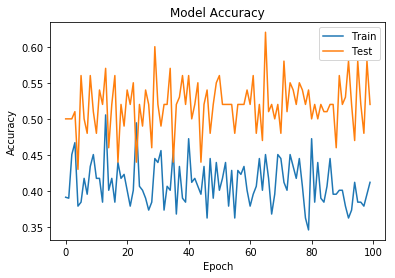

In [22]:
import matplotlib.pyplot as plt
#visualizing training history

plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc="Lower right")
plt.show()

##### Model defined with 
- batch_size = 30 , num_epochs = 100
- img_idx =  [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [23]:
# Parameters initialization
batch_size = 30
num_epochs = 100 # choose the number of epochs
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
img_idx =  [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]
nb_frames = len(img_idx)  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list =  [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = Source path =  ./Project_data/train ; batch size = 30
Epoch 1/100
30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/23 [==>...........................] - ETA: 30s - loss: 1.4435 - categorical_accuracy: 0.3889

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 28s 1s/step - loss: 1.4104 - categorical_accuracy: 0.4101 - val_loss: 1.6499 - val_categorical_accuracy: 0.4750

Epoch 00001: saving model to model_init_2019-12-2407_30_25.158041/model-00001-1.41038-0.41014-1.64994-0.47500.h5
Epoch 2/100
23/23 [==============================] - 2s 90ms/step - loss: 1.5953 - categorical_accuracy: 0.2319 - val_loss: 1.4430 - val_categorical_accuracy: 0.5250

Epoch 00002: saving model to model_init_2019-12-2407_30_25.158041/model-00002-1.59529-0.23188-1.44300-0.52500.h5
Epoch 3/100
23/23 [==============================] - 3s 150ms/step - loss: 1.5166 - categorical_accuracy: 0.2609 - val_loss: 1.3613 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2019-12-2407_30_25.158041/model-00003-1.51655-0.26087-1.36131-0.50000.h5
Epoch 4/100
23/23 [==============================] - 4s 156ms/step - loss: 1.4598 - categorical_accuracy: 0.3478 - val_loss: 1.3576 - val_categorical_accuracy: 0.5250

Epoc

23/23 [==============================] - 3s 141ms/step - loss: 1.4136 - categorical_accuracy: 0.4058 - val_loss: 1.4206 - val_categorical_accuracy: 0.4500

Epoch 00053: saving model to model_init_2019-12-2407_30_25.158041/model-00053-1.41364-0.40580-1.42064-0.45000.h5
Epoch 54/100
23/23 [==============================] - 3s 130ms/step - loss: 1.4368 - categorical_accuracy: 0.4638 - val_loss: 1.3704 - val_categorical_accuracy: 0.6250

Epoch 00054: saving model to model_init_2019-12-2407_30_25.158041/model-00054-1.43683-0.46377-1.37041-0.62500.h5

Epoch 00054: ReduceLROnPlateau reducing learning rate to 6.617444752512802e-26.
Epoch 55/100
23/23 [==============================] - 3s 142ms/step - loss: 1.4553 - categorical_accuracy: 0.3478 - val_loss: 1.4274 - val_categorical_accuracy: 0.4500

Epoch 00055: saving model to model_init_2019-12-2407_30_25.158041/model-00055-1.45525-0.34783-1.42736-0.45000.h5
Epoch 56/100
23/23 [==============================] - 3s 133ms/step - loss: 1.3870 - c

23/23 [==============================] - 3s 130ms/step - loss: 1.4682 - categorical_accuracy: 0.2609 - val_loss: 1.4820 - val_categorical_accuracy: 0.4000

Epoch 00079: saving model to model_init_2019-12-2407_30_25.158041/model-00079-1.46823-0.26087-1.48204-0.40000.h5
Epoch 80/100
23/23 [==============================] - 3s 136ms/step - loss: 1.3844 - categorical_accuracy: 0.3768 - val_loss: 1.3467 - val_categorical_accuracy: 0.5750

Epoch 00080: saving model to model_init_2019-12-2407_30_25.158041/model-00080-1.38445-0.37681-1.34668-0.57500.h5

Epoch 00080: ReduceLROnPlateau reducing learning rate to 8.077935488907229e-30.
Epoch 81/100
23/23 [==============================] - 3s 129ms/step - loss: 1.3774 - categorical_accuracy: 0.4203 - val_loss: 1.3702 - val_categorical_accuracy: 0.7000

Epoch 00081: saving model to model_init_2019-12-2407_30_25.158041/model-00081-1.37739-0.42029-1.37018-0.70000.h5
Epoch 82/100
23/23 [==============================] - 3s 112ms/step - loss: 1.4284 - c

#### Plotting the result in graph

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Lower right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


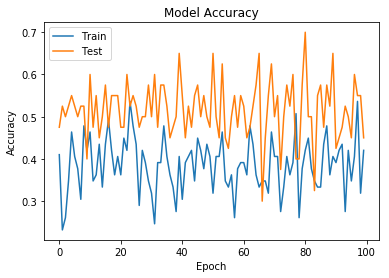

In [24]:
import matplotlib.pyplot as plt
#visualizing training history

plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc="Lower right")
plt.show()

##### Model defined with 
- batch_size = 10 , num_epochs = 100
- img_idx =  [0 - 30]

In [28]:
# Parameters initialization
batch_size = 10
num_epochs = 100 # choose the number of epochs
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
img_idx =  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30]
nb_frames = len(img_idx)  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list =  [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size =Source path =  ./Project_data/train ; batch size = 10
 10
Epoch 1/100


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


66/67 [============================>.] - ETA: 0s - loss: 1.4087 - categorical_accuracy: 0.4061

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 27s 400ms/step - loss: 1.4174 - categorical_accuracy: 0.4045 - val_loss: 1.4000 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2019-12-2407_30_25.158041/model-00001-1.41741-0.40448-1.39998-0.50000.h5
Epoch 2/100
67/67 [==============================] - 9s 134ms/step - loss: 1.4914 - categorical_accuracy: 0.3532 - val_loss: 1.3816 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2019-12-2407_30_25.158041/model-00002-1.49135-0.35323-1.38157-0.52000.h5
Epoch 3/100
67/67 [==============================] - 9s 135ms/step - loss: 1.4074 - categorical_accuracy: 0.4229 - val_loss: 1.4015 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2019-12-2407_30_25.158041/model-00003-1.40736-0.42289-1.40149-0.52000.h5
Epoch 4/100
67/67 [==============================] - 9s 134ms/step - loss: 1.4558 - categorical_accuracy: 0.3831 - val_loss: 1.3745 - val_categorical_accuracy: 0.5300



67/67 [==============================] - 9s 130ms/step - loss: 1.3766 - categorical_accuracy: 0.4229 - val_loss: 1.3724 - val_categorical_accuracy: 0.5300

Epoch 00059: saving model to model_init_2019-12-2407_30_25.158041/model-00059-1.37660-0.42289-1.37244-0.53000.h5
Epoch 60/100
67/67 [==============================] - 9s 137ms/step - loss: 1.4628 - categorical_accuracy: 0.3532 - val_loss: 1.3590 - val_categorical_accuracy: 0.4900

Epoch 00060: saving model to model_init_2019-12-2407_30_25.158041/model-00060-1.46281-0.35323-1.35898-0.49000.h5
Epoch 61/100
67/67 [==============================] - 9s 131ms/step - loss: 1.4656 - categorical_accuracy: 0.3632 - val_loss: 1.3538 - val_categorical_accuracy: 0.5700

Epoch 00061: saving model to model_init_2019-12-2407_30_25.158041/model-00061-1.46558-0.36318-1.35376-0.57000.h5
Epoch 62/100
67/67 [==============================] - 9s 130ms/step - loss: 1.4688 - categorical_accuracy: 0.3930 - val_loss: 1.4349 - val_categorical_accuracy: 0.4800

#### Plotting the result in graph

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Lower right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


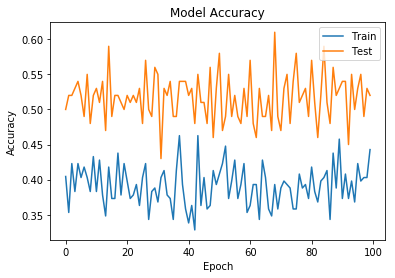

In [30]:
import matplotlib.pyplot as plt
#visualizing training history

plt.plot(history4.history['categorical_accuracy'])
plt.plot(history4.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc="Lower right")
plt.show()

##### Model defined with 
- batch_size = 50 , num_epochs = 30
- img_idx =  [0-30]

In [31]:
# Parameters initialization
batch_size = 50
num_epochs = 30 # choose the number of epochs
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
img_idx =  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30]
nb_frames = len(img_idx)  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list =  [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 50
Source path =  Epoch 1/30
./Project_data/train ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 4s - loss: 1.4160 - categorical_accuracy: 0.4017

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 30s 2s/step - loss: 1.4413 - categorical_accuracy: 0.4086 - val_loss: 1.3958 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2019-12-2407_30_25.158041/model-00001-1.44130-0.40857-1.39576-0.52000.h5
Epoch 2/30
14/14 [==============================] - 7s 528ms/step - loss: 1.4412 - categorical_accuracy: 0.3571 - val_loss: 1.5137 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2019-12-2407_30_25.158041/model-00002-1.44116-0.35714-1.51369-0.41000.h5
Epoch 3/30
14/14 [==============================] - 8s 568ms/step - loss: 1.3837 - categorical_accuracy: 0.3956 - val_loss: 1.2541 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2019-12-2407_30_25.158041/model-00003-1.38365-0.39560-1.25409-0.64000.h5
Epoch 4/30
14/14 [==============================] - 8s 540ms/step - loss: 1.3653 - categorical_accuracy: 0.4835 - val_loss: 1.3978 - val_categorical_accuracy: 0.5200

Epoch 

##### Plotting the result in graph

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Lower right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


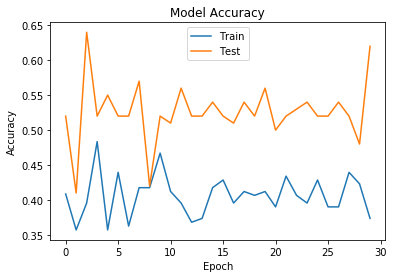

In [32]:
import matplotlib.pyplot as plt
#visualizing training history

plt.plot(history5.history['categorical_accuracy'])
plt.plot(history5.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc="Lower right")
plt.show()

In [13]:
# Parameters initialization
batch_size = 50
num_epochs = 100 # choose the number of epochs
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
img_idx =  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30]
nb_frames = len(img_idx)  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list =  [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/100


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 16s - loss: 2.1516 - categorical_accuracy: 0.2167

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 111s 8s/step - loss: 2.0940 - categorical_accuracy: 0.2343 - val_loss: 1.6254 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to model_init_2019-12-2410_04_02.911315/model-00001-2.09399-0.23429-1.62539-0.17000.h5
Epoch 2/100
14/14 [==============================] - 8s 589ms/step - loss: 1.8006 - categorical_accuracy: 0.2527 - val_loss: 1.6740 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2019-12-2410_04_02.911315/model-00002-1.80056-0.25275-1.67396-0.24000.h5
Epoch 3/100
14/14 [==============================] - 10s 687ms/step - loss: 1.6958 - categorical_accuracy: 0.1923 - val_loss: 1.4945 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2019-12-2410_04_02.911315/model-00003-1.69577-0.19231-1.49453-0.26000.h5
Epoch 4/100
14/14 [==============================] - 9s 616ms/step - loss: 1.5903 - categorical_accuracy: 0.2473 - val_loss: 1.5606 - val_categorical_accuracy: 0.3000

E

14/14 [==============================] - 7s 519ms/step - loss: 1.1534 - categorical_accuracy: 0.5165 - val_loss: 1.1745 - val_categorical_accuracy: 0.5700

Epoch 00028: saving model to model_init_2019-12-2410_04_02.911315/model-00028-1.15338-0.51648-1.17455-0.57000.h5
Epoch 29/100
14/14 [==============================] - 8s 571ms/step - loss: 1.1513 - categorical_accuracy: 0.5110 - val_loss: 1.2055 - val_categorical_accuracy: 0.5900

Epoch 00029: saving model to model_init_2019-12-2410_04_02.911315/model-00029-1.15134-0.51099-1.20549-0.59000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 30/100
14/14 [==============================] - 8s 577ms/step - loss: 1.1212 - categorical_accuracy: 0.5495 - val_loss: 1.1625 - val_categorical_accuracy: 0.5400

Epoch 00030: saving model to model_init_2019-12-2410_04_02.911315/model-00030-1.12123-0.54945-1.16247-0.54000.h5
Epoch 31/100
14/14 [==============================] - 7s 484ms/step - loss: 1.1300 - 

14/14 [==============================] - 8s 564ms/step - loss: 1.1125 - categorical_accuracy: 0.5769 - val_loss: 1.0529 - val_categorical_accuracy: 0.6200

Epoch 00054: saving model to model_init_2019-12-2410_04_02.911315/model-00054-1.11254-0.57692-1.05288-0.62000.h5
Epoch 55/100
14/14 [==============================] - 7s 528ms/step - loss: 1.0429 - categorical_accuracy: 0.5934 - val_loss: 1.1601 - val_categorical_accuracy: 0.5500

Epoch 00055: saving model to model_init_2019-12-2410_04_02.911315/model-00055-1.04286-0.59341-1.16009-0.55000.h5
Epoch 56/100
14/14 [==============================] - 7s 532ms/step - loss: 1.2499 - categorical_accuracy: 0.4231 - val_loss: 1.1631 - val_categorical_accuracy: 0.5400

Epoch 00056: saving model to model_init_2019-12-2410_04_02.911315/model-00056-1.24989-0.42308-1.16312-0.54000.h5

Epoch 00056: ReduceLROnPlateau reducing learning rate to 3.814697180359872e-08.
Epoch 57/100
14/14 [==============================] - 7s 534ms/step - loss: 1.1623 - c

14/14 [==============================] - 8s 552ms/step - loss: 1.1345 - categorical_accuracy: 0.5275 - val_loss: 1.1680 - val_categorical_accuracy: 0.5000

Epoch 00080: saving model to model_init_2019-12-2410_04_02.911315/model-00080-1.13452-0.52747-1.16803-0.50000.h5

Epoch 00080: ReduceLROnPlateau reducing learning rate to 9.313225537987968e-12.
Epoch 81/100
14/14 [==============================] - 8s 562ms/step - loss: 1.1212 - categorical_accuracy: 0.5165 - val_loss: 1.2250 - val_categorical_accuracy: 0.5400

Epoch 00081: saving model to model_init_2019-12-2410_04_02.911315/model-00081-1.12120-0.51648-1.22495-0.54000.h5
Epoch 82/100
14/14 [==============================] - 7s 535ms/step - loss: 1.2069 - categorical_accuracy: 0.4505 - val_loss: 1.1598 - val_categorical_accuracy: 0.5500

Epoch 00082: saving model to model_init_2019-12-2410_04_02.911315/model-00082-1.20689-0.45055-1.15980-0.55000.h5

Epoch 00082: ReduceLROnPlateau reducing learning rate to 4.656612768993984e-12.
Epoch

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Lower right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


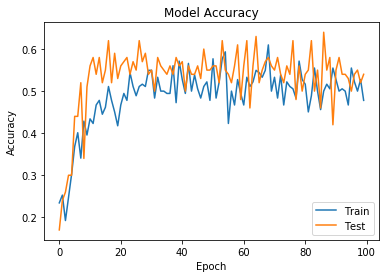

In [14]:
import matplotlib.pyplot as plt
#visualizing training history

plt.plot(history6.history['categorical_accuracy'])
plt.plot(history6.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc="Lower right")
plt.show()